# GLM with pytorch helper functions

In [64]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.io
from utilities.izhikevich_neuron import generate_izhikevich_stim, simulate_izhikevich

#Load the .mat file
file_path = 'PixON_vectors.mat'  # Replace with the actual path to your file
mat_data = scipy.io.loadmat(file_path)
# # Extract the relevant data from the .mat file
# I = mat_data['I'].flatten()
# spikes = mat_data['spikes'].flatten()
#dt = mat_data['dt'].flatten()[0]


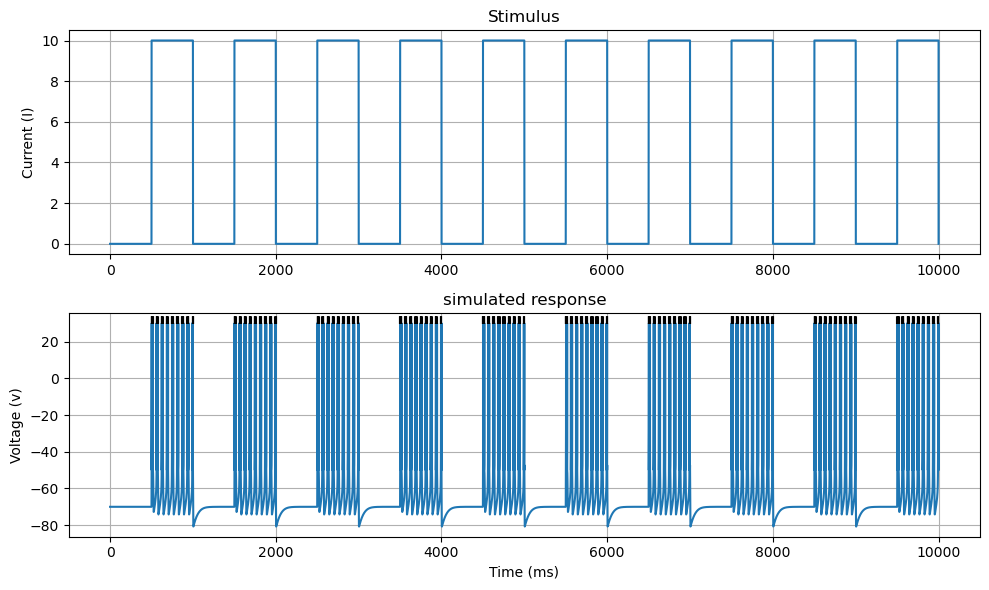

In [65]:
# Generate stimulus (from previous function)
T = 10000
celltype =3
I, dt = generate_izhikevich_stim(celltype, T)
# Simulate and plot the results
v, u, spikes, cid = simulate_izhikevich(celltype, I, dt, jitter=1, plotFlag=True, saveFlag=False)


In [66]:
print(dt)

0.1


In [67]:
# Define the history window and stimulus window (e.g., 50 ms for both)
history_bins = 10
stimulus_bins = 10

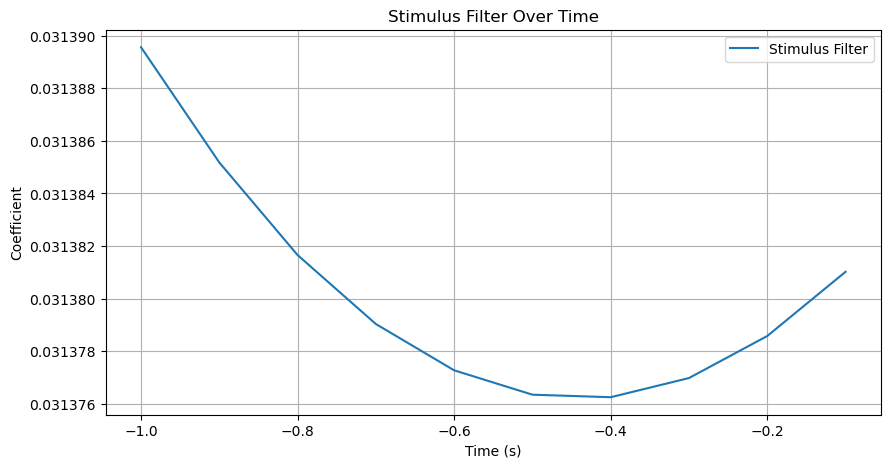

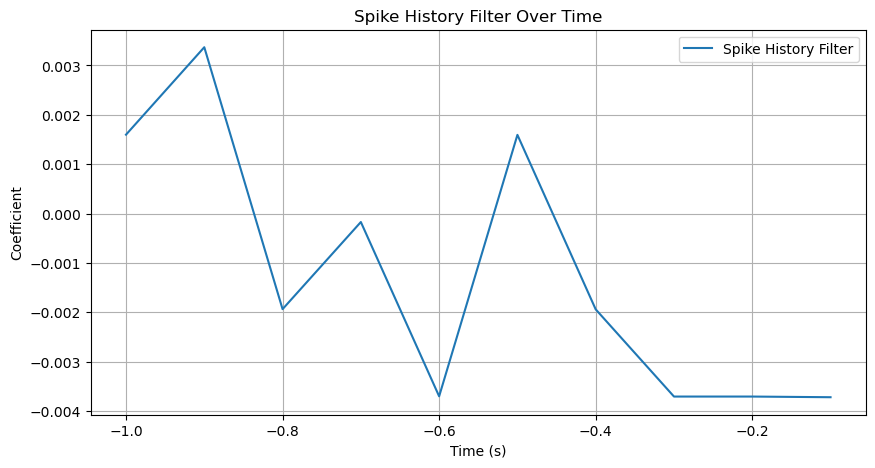

In [68]:
def build_design_matrix_with_stimulus_filter(I, spikes, history_bins, stimulus_bins):
    n_time_points = len(I)
    
    # Stimulus filter: lagged versions of the stimulus (injected current)
    X_stimulus = np.zeros((n_time_points, stimulus_bins))
    for t in range(stimulus_bins, n_time_points):
        X_stimulus[t, :] = I[t-stimulus_bins:t]
    
    # Spike history filter: lagged versions of the spike train
    X_spike_history = np.zeros((n_time_points, history_bins))
    for t in range(history_bins, n_time_points):
        X_spike_history[t, :] = spikes[t-history_bins:t]
    
    # Combine stimulus and spike history filters
    X = np.hstack([X_stimulus, X_spike_history])
    
    return X

# Build the design matrix with temporal filters for both stimulus and spike history
X = build_design_matrix_with_stimulus_filter(I, spikes, history_bins, stimulus_bins)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-fold cross-validation with a Poisson GLM
kf = KFold(n_splits=5)
l2_penalties = [0.1, 1, 10]

# Variables to store the best model
best_model = None
best_score = -np.inf

# Cross-validation loop
for penalty in l2_penalties:
    fold_scores = []
    
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = spikes[train_index], spikes[test_index]
        
        # Initialize the Poisson GLM with L2 regularization (alpha = L2 penalty)
        model = PoissonRegressor(alpha=penalty, max_iter=1000)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Evaluate the model on the test set
        score = model.score(X_test, y_test)  # R^2 score
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Retrieve the best model coefficients for stimulus and spike history filters
stimulus_filter = best_model.coef_[:stimulus_bins]
spike_history_filter = best_model.coef_[stimulus_bins:]

# Time vectors for stimulus and spike history filters
stimulus_time = np.arange(-stimulus_bins * dt, 0, dt)
history_time = np.arange(-history_bins * dt, 0, dt)

# Plot the stimulus filter
plt.figure(figsize=(10, 5))
plt.plot(stimulus_time, stimulus_filter, label='Stimulus Filter')
plt.title('Stimulus Filter Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()

# Plot the spike history filter
plt.figure(figsize=(10, 5))
plt.plot(history_time, spike_history_filter, label='Spike History Filter')
plt.title('Spike History Filter Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()


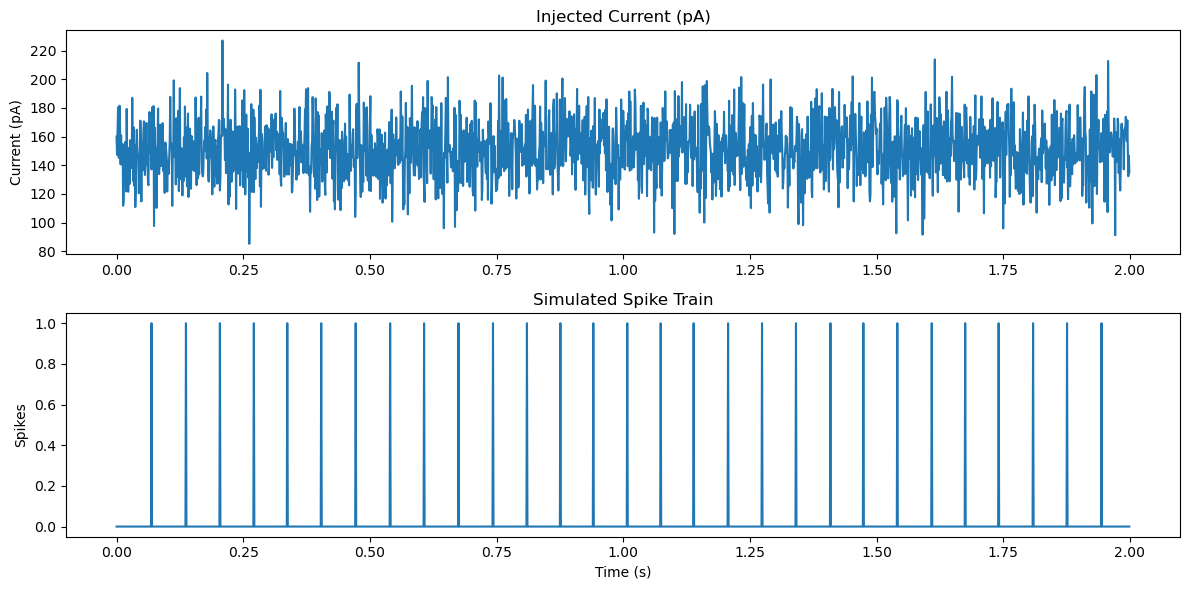

In [69]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# LIF Neuron Model
def lif_neuron(I, dt, V_rest=-65, V_th=-55, V_reset=-65, tau_m=10, R=10, T=1.0):
    n_steps = int(T / dt)  # Number of time steps
    V = np.zeros(n_steps)  # Membrane potential
    V[0] = V_rest  # Initialize at resting potential
    spikes = np.zeros(n_steps)  # Spike train
    
    # Simulate the LIF neuron dynamics
    for t in range(1, n_steps):
        dV = (-(V[t-1] - V_rest) + R * I[t]) / tau_m * dt
        V[t] = V[t-1] + dV
        
        if V[t] >= V_th:
            spikes[t] = 1  # Spike
            V[t] = V_reset  # Reset the potential
            
    return spikes, V

# Parameters for simulation
T = 2.0  # 2 seconds of simulation
dt = 0.001  # 1 ms time step
time = np.arange(0, T, dt)  # Time vector

# Create a time-varying injected current (e.g., random fluctuations + constant input)
np.random.seed(42)
I_injected = 150 + 20 * np.random.randn(len(time))  # Higher mean current + random fluctuations

# Simulate LIF neuron with the adjusted current
spikes_lif, V_lif = lif_neuron(I_injected, dt, T=T)

# Plot the injected current and spike train
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, I_injected)
plt.title('Injected Current (pA)')
plt.ylabel('Current (pA)')

plt.subplot(2, 1, 2)
plt.plot(time, spikes_lif, label='Spikes')
plt.title('Simulated Spike Train')
plt.ylabel('Spikes')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


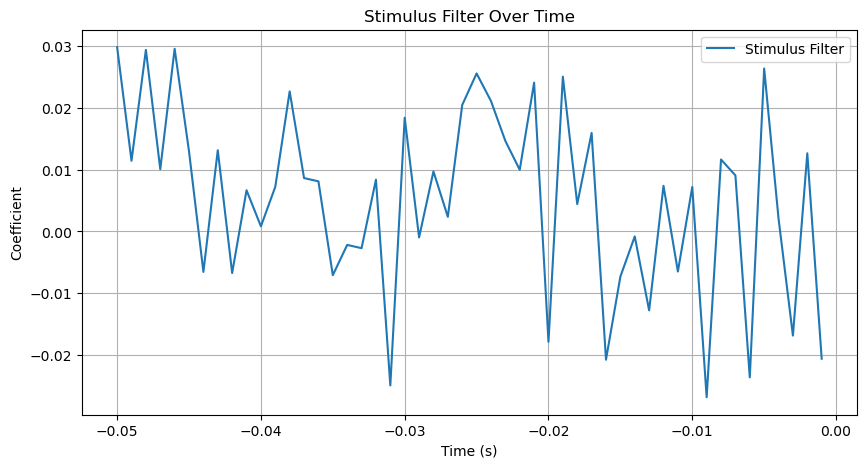

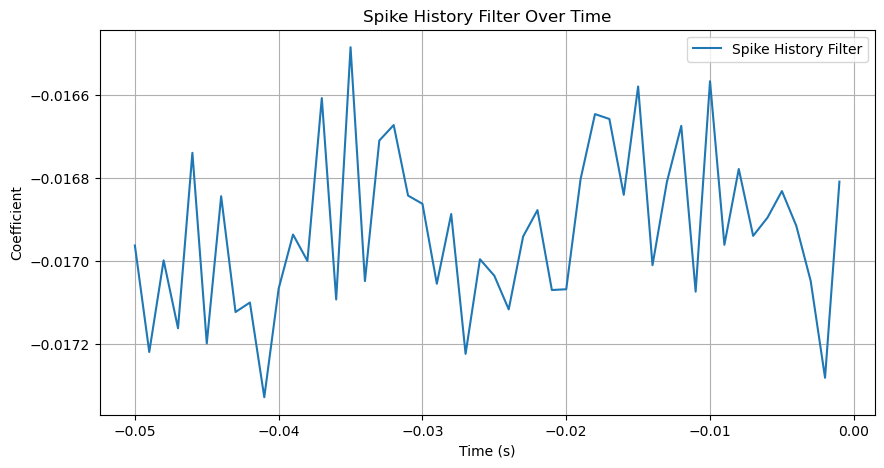

In [70]:
##Build the design matrix
def build_design_matrix_with_stimulus_filter(I, spikes, history_bins, stimulus_bins):
    n_time_points = len(I)
    
    # Stimulus filter: lagged versions of the stimulus (injected current)
    X_stimulus = np.zeros((n_time_points, stimulus_bins))
    for t in range(stimulus_bins, n_time_points):
        X_stimulus[t, :] = I[t-stimulus_bins:t]
    
    # Spike history filter: lagged versions of the spike train
    X_spike_history = np.zeros((n_time_points, history_bins))
    for t in range(history_bins, n_time_points):
        X_spike_history[t, :] = spikes[t-history_bins:t]
    
    # Combine stimulus and spike history filters
    X = np.hstack([X_stimulus, X_spike_history])
    
    return X

# Define history window for both stimulus and spike history filters (e.g., 50 ms)
history_bins = int(0.05 / dt)
stimulus_bins = int(0.05 / dt)

# Build the design matrix with temporal filters for both stimulus and spike history
X_lif = build_design_matrix_with_stimulus_filter(I_injected, spikes_lif, history_bins, stimulus_bins)

# Standardize the features
scaler = StandardScaler()
X_lif_scaled = scaler.fit_transform(X_lif)

# Perform k-fold cross-validation with a Poisson GLM
kf = KFold(n_splits=5)
l2_penalties = [0.1, 1, 10]  # L2 regularization grid
best_model = None
best_score = -np.inf

# Cross-validation loop
for penalty in l2_penalties:
    fold_scores = []
    
    for train_index, test_index in kf.split(X_lif_scaled):
        X_train, X_test = X_lif_scaled[train_index], X_lif_scaled[test_index]
        y_train, y_test = spikes_lif[train_index], spikes_lif[test_index]
        
        # Initialize the Poisson GLM with L2 regularization (alpha = L2 penalty)
        model = PoissonRegressor(alpha=penalty, max_iter=1000)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Evaluate the model on the test set
        score = model.score(X_test, y_test)  # R^2 score
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Retrieve the best model coefficients for stimulus and spike history filters
stimulus_filter = best_model.coef_[:stimulus_bins]
spike_history_filter = best_model.coef_[stimulus_bins:]

# Time vectors for stimulus and spike history filters
stimulus_time = np.arange(-stimulus_bins * dt, 0, dt)
history_time = np.arange(-history_bins * dt, 0, dt)

# Plot the stimulus filter
plt.figure(figsize=(10, 5))
plt.plot(stimulus_time, stimulus_filter, label='Stimulus Filter')
plt.title('Stimulus Filter Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()

# Plot the spike history filter
plt.figure(figsize=(10, 5))
plt.plot(history_time, spike_history_filter, label='Spike History Filter')
plt.title('Spike History Filter Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()

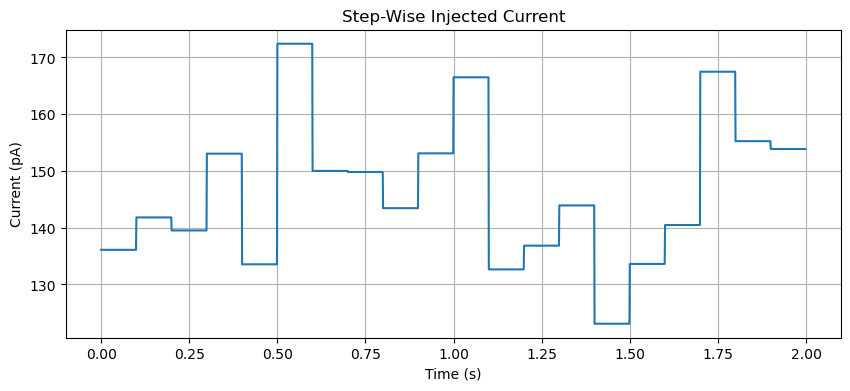

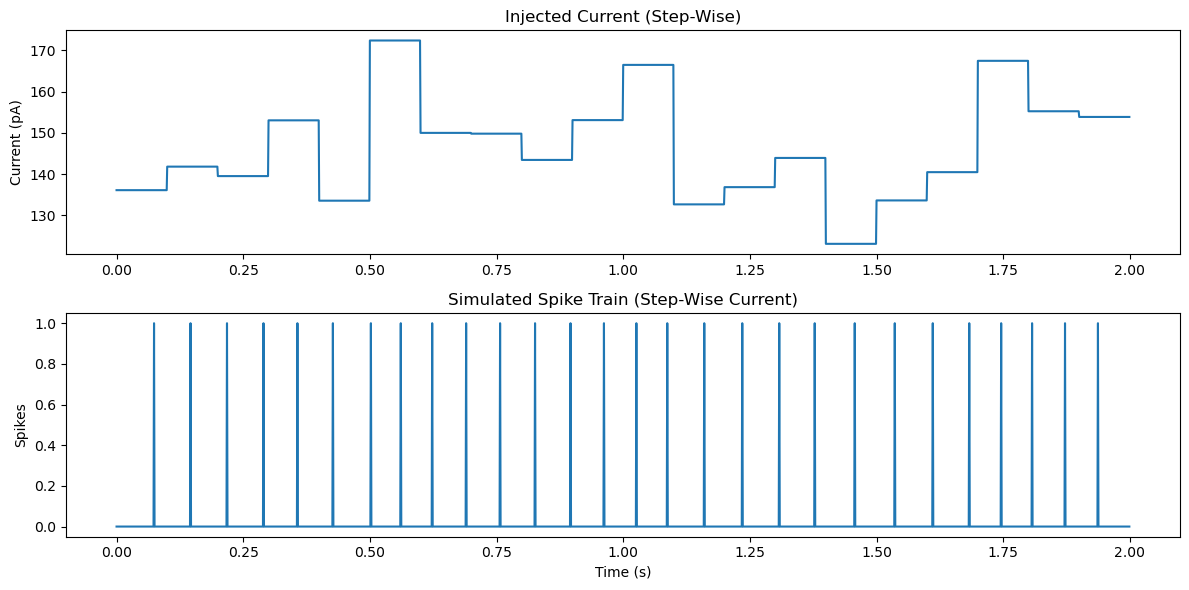

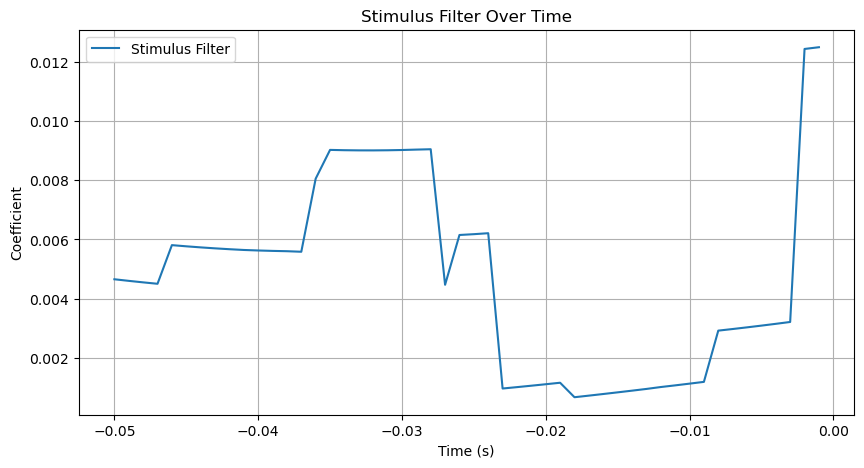

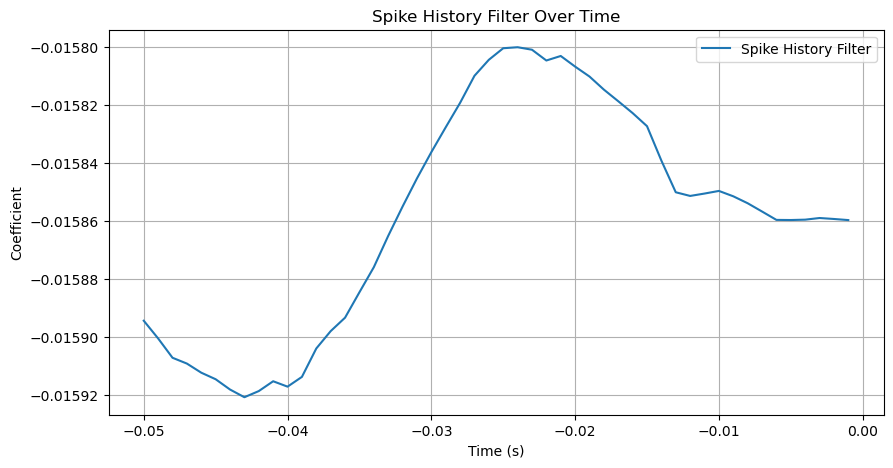

In [73]:

import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# LIF Neuron Model
def lif_neuron(I, dt, V_rest=-65, V_th=-55, V_reset=-65, tau_m=10, R=10, T=1.0):
    n_steps = int(T / dt)  # Number of time steps
    V = np.zeros(n_steps)  # Membrane potential
    V[0] = V_rest  # Initialize at resting potential
    spikes = np.zeros(n_steps)  # Spike train
    
    # Simulate the LIF neuron dynamics
    for t in range(1, n_steps):
        dV = (-(V[t-1] - V_rest) + R * I[t]) / tau_m * dt
        V[t] = V[t-1] + dV
        
        if V[t] >= V_th:
            spikes[t] = 1  # Spike
            V[t] = V_reset  # Reset the potential
            
    return spikes, V

# Parameters for simulation
T = 2.0  # 2 seconds of simulation
dt = 0.001  # 1 ms time step
time = np.arange(0, T, dt)  # Time vector

# Generate step-wise injected current
def generate_step_current(time, step_duration, mean=150, std=20):
    """
    Generate a step-wise injected current where each step has a mean drawn from a Gaussian distribution.
    
    Parameters:
    - time: Time vector (array)
    - step_duration: Duration of each step in seconds
    - mean: Mean of the Gaussian distribution for current means
    - std: Standard deviation of the Gaussian distribution for current means
    
    Returns:
    - I_step: Step-wise injected current (array)
    """
    n_steps = int(len(time) * dt / step_duration)  # Number of steps
    step_means = np.random.normal(mean, std, n_steps)  # Random mean for each step
    I_step = np.zeros(len(time))
    
    # Assign each step mean to the corresponding time window
    for i in range(n_steps):
        start_idx = int(i * step_duration / dt)
        end_idx = int((i + 1) * step_duration / dt)
        I_step[start_idx:end_idx] = step_means[i]
    
    return I_step

# Parameters for the step current
step_duration = 0.1  # Each step lasts 100 ms

# Generate the step-wise injected current
I_injected_step = generate_step_current(time, step_duration)

# Plot the new step-wise injected current
plt.figure(figsize=(10, 4))
plt.plot(time, I_injected_step)
plt.title('Step-Wise Injected Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (pA)')
plt.grid(True)
plt.show()

# Simulate LIF neuron with the step-wise injected current
spikes_lif_step, V_lif_step = lif_neuron(I_injected_step, dt, T=T)

# Plot the step-wise injected current and the resulting spike train
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, I_injected_step)
plt.title('Injected Current (Step-Wise)')
plt.ylabel('Current (pA)')

plt.subplot(2, 1, 2)
plt.plot(time, spikes_lif_step, label='Spikes')
plt.title('Simulated Spike Train (Step-Wise Current)')
plt.ylabel('Spikes')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Build the design matrix
def build_design_matrix_with_stimulus_filter(I, spikes, history_bins, stimulus_bins):
    n_time_points = len(I)
    
    # Stimulus filter: lagged versions of the stimulus (injected current)
    X_stimulus = np.zeros((n_time_points, stimulus_bins))
    for t in range(stimulus_bins, n_time_points):
        X_stimulus[t, :] = I[t-stimulus_bins:t]
    
    # Spike history filter: lagged versions of the spike train
    X_spike_history = np.zeros((n_time_points, history_bins))
    for t in range(history_bins, n_time_points):
        X_spike_history[t, :] = spikes[t-history_bins:t]
    
    # Combine stimulus and spike history filters
    X = np.hstack([X_stimulus, X_spike_history])
    
    return X

# Define history window for both stimulus and spike history filters (e.g., 50 ms)
history_bins = int(0.05 / dt)
stimulus_bins = int(0.05 / dt)

# Build the design matrix with temporal filters for both stimulus and spike history
X_lif = build_design_matrix_with_stimulus_filter(I_injected_step, spikes_lif_step, history_bins, stimulus_bins)

# Standardize the features
scaler = StandardScaler()
X_lif_scaled = scaler.fit_transform(X_lif)

# Perform k-fold cross-validation with a Poisson GLM
kf = KFold(n_splits=5)
l2_penalties = [0.1, 1, 10]  # L2 regularization grid
best_model = None
best_score = -np.inf

# Cross-validation loop
for penalty in l2_penalties:
    fold_scores = []
    
    for train_index, test_index in kf.split(X_lif_scaled):
        X_train, X_test = X_lif_scaled[train_index], X_lif_scaled[test_index]
        y_train, y_test = spikes_lif_step[train_index], spikes_lif_step[test_index]
        
        # Initialize the Poisson GLM with L2 regularization (alpha = L2 penalty)
        model = PoissonRegressor(alpha=penalty, max_iter=1000)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Evaluate the model on the test set
        score = model.score(X_test, y_test)  # R^2 score
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Retrieve the best model coefficients for stimulus and spike history filters
stimulus_filter = best_model.coef_[:stimulus_bins]
spike_history_filter = best_model.coef_[stimulus_bins:]

# Time vectors for stimulus and spike history filters
stimulus_time = np.arange(-stimulus_bins * dt, 0, dt)
history_time = np.arange(-history_bins * dt, 0, dt)

# Plot the stimulus filter
plt.figure(figsize=(10, 5))
plt.plot(stimulus_time, stimulus_filter, label='Stimulus Filter')
plt.title('Stimulus Filter Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()

# Plot the spike history filter
plt.figure(figsize=(10, 5))
plt.plot(history_time, spike_history_filter, label='Spike History Filter')
plt.title('Spike History Filter Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()


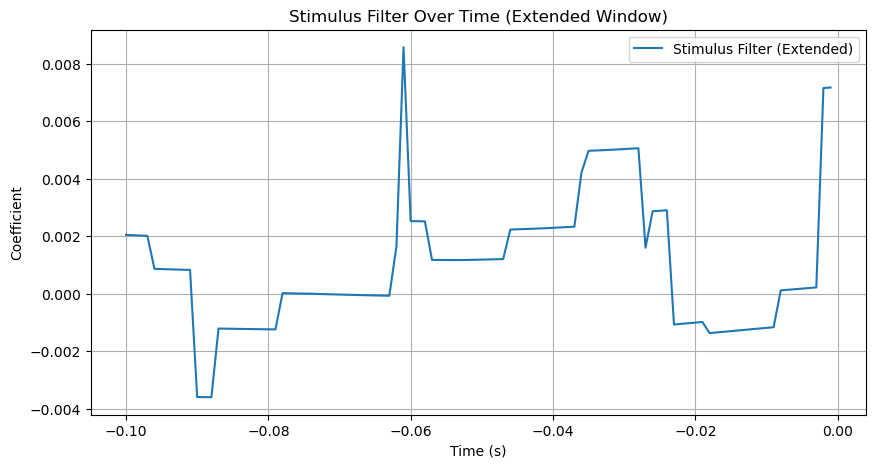

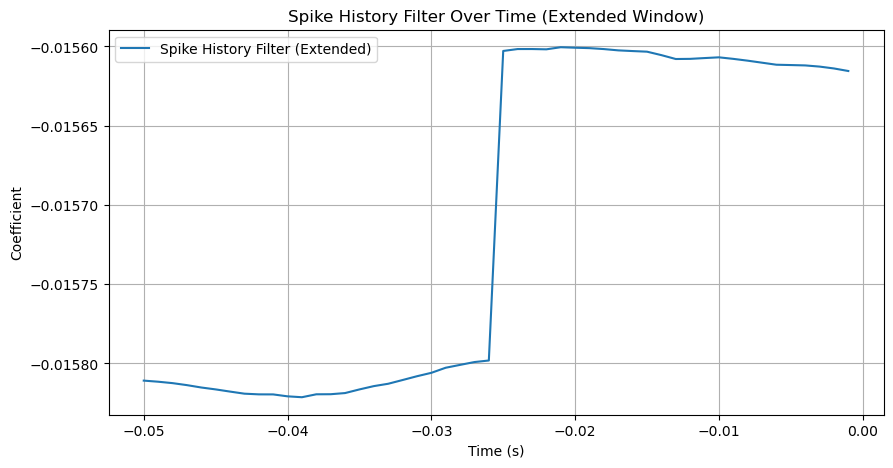

In [74]:
# Increase the number of stimulus bins and apply stronger regularization

# Increase the stimulus window to better capture exponential decay (e.g., 100 ms window)
stimulus_bins_extended = int(0.1 / dt)

# Update the L2 regularization penalties to explore stronger regularization
l2_penalties_extended = [0.1, 1, 10, 100, 1000]

# Build the design matrix with the extended stimulus window
X_lif_extended = build_design_matrix_with_stimulus_filter(I_injected_step, spikes_lif_step, history_bins, stimulus_bins_extended)

# Standardize the features
X_lif_scaled_extended = scaler.fit_transform(X_lif_extended)

# Perform k-fold cross-validation with the extended L2 penalties and stimulus window
cv_scores_lif_extended = []
best_model_extended = None
best_score_extended = -np.inf

# Cross-validation loop for the extended stimulus window and penalties
for penalty in l2_penalties_extended:
    fold_scores_extended = []
    
    for train_index, test_index in kf.split(X_lif_scaled_extended):
        X_train_ext, X_test_ext = X_lif_scaled_extended[train_index], X_lif_scaled_extended[test_index]
        y_train_ext, y_test_ext = spikes_lif_step[train_index], spikes_lif_step[test_index]
        
        # Initialize the Poisson GLM with L2 regularization
        model_extended = PoissonRegressor(alpha=penalty, max_iter=1000)
        
        # Fit the model
        model_extended.fit(X_train_ext, y_train_ext)
        
        # Evaluate the model
        score_extended = model_extended.score(X_test_ext, y_test_ext)
        fold_scores_extended.append(score_extended)
    
    mean_score_extended = np.mean(fold_scores_extended)
    cv_scores_lif_extended.append(mean_score_extended)
    
    if mean_score_extended > best_score_extended:
        best_score_extended = mean_score_extended
        best_model_extended = model_extended

# Retrieve the best model coefficients for the extended stimulus and spike history filters
stimulus_filter_extended = best_model_extended.coef_[:stimulus_bins_extended]
spike_history_filter_extended = best_model_extended.coef_[stimulus_bins_extended:]

# Time vectors for the extended stimulus and spike history filters
stimulus_time_extended = np.arange(-stimulus_bins_extended * dt, 0, dt)
history_time_extended = np.arange(-history_bins * dt, 0, dt)

# Plot the extended stimulus filter to see if it captures the exponential dynamics
plt.figure(figsize=(10, 5))
plt.plot(stimulus_time_extended, stimulus_filter_extended, label='Stimulus Filter (Extended)')
plt.title('Stimulus Filter Over Time (Extended Window)')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()

# Plot the spike history filter for comparison
plt.figure(figsize=(10, 5))
plt.plot(history_time_extended, spike_history_filter_extended, label='Spike History Filter (Extended)')
plt.title('Spike History Filter Over Time (Extended Window)')
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.grid(True)
plt.legend()
plt.show()
